# Week 2: CostPro Customer Behavior



🚨 **First things first! Make a copy of this notebook. Your changes will not save unless you create your own copy!**

💡 Build Intuition

As a data scientist at CostPro, your goal is to collect and analyze data on various factors influencing the likelihood of a purchase, such as a customer's past purchasing history, online behavior, and demographic information.

You'll use probability distributions to model customer behavior, to determine how likely different outcomes are.

## 🚀 Project Setup

First, we need to download and import all of the dependencies that we will need for the project

### Dependencies

In [1]:
# Install all required dependencies for the project
!pip install -qqq numpy pandas seaborn matplotlib gdown plotly scipy
# We need this to avoid version incompatibilities between packages (please ignore any warnings)
!pip install --force-reinstall --ignore-installed -qqq protobuf==3.20

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-cloud-bigquery 3.10.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-cloud-bigquery-connection 1.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-cloud-bigquery-storage 2.22.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.

In [2]:
# Import dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import shutil
from scipy.stats import poisson, binom, norm, skew, kurtosis, probplot, loggamma
import gdown
from google.colab import files

# [TO BE IMPLEMENTED]
# Feel free to add any other imports that you need to write your own custom metrics

## Data

[Online Retail](https://archive.ics.uci.edu/ml/datasets/online+retail) is a collection of roughly 400,000 records from an international online retail dataset. For this project, we will use a slightly modified (cleaned up) version of this dataset as the sales data for CostPro.

### Download the Dataset

In [3]:
# Download the file from co:rise google drive
file_name = "online_retail.csv"
unique_id = "16HZKULqv2sX6AMqi4A8ndQ9ULeCLo4Qt"
gdown.download(id=unique_id, output=file_name)

Downloading...
From: https://drive.google.com/uc?id=16HZKULqv2sX6AMqi4A8ndQ9ULeCLo4Qt
To: /content/online_retail.csv
100%|██████████| 44.5M/44.5M [00:00<00:00, 62.6MB/s]


'online_retail.csv'

Now we need to create a directory. This will be used to store the files that you will need to produce your dashboard.

In [4]:
# Create the directory
!mkdir -p retail_metrics_dashboard

### Clean & Prepare the Dataset

Now we'll import the data as a pandas dataframe. The code below will show you the first 5 rows of the dataframe, but feel free to explore the data further!

In [5]:
# import data and show first 5 rows
data = pd.read_csv(file_name)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/21 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/21 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/21 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/21 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/21 8:26,3.39,17850.0,United Kingdom


## Project Jumpstart

### Explore Basic Statistics You Get Out of the Box with Pandas

In [6]:
# check record count and column count
data.shape

(541909, 8)

In [7]:
# review basic information about the dataset including column names, data types, non-null counts, and memory usage
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
# check the number of missing values in each column
data.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

On the job, you'll need to explore if there are specific patterns to the missing values. For the sake of expediency and simplicity in this project, we'll drop them.

In [9]:
# Drop missing values and validate that there are no missing values after the fix
data = data.dropna().reset_index(drop=True)
data.isnull().sum(axis=0)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [10]:
# Check the number of unique values in each column
data.nunique()

InvoiceNo      22190
StockCode       3684
Description     3896
Quantity         436
InvoiceDate    20460
UnitPrice        620
CustomerID      4372
Country           37
dtype: int64

In [11]:
# Use pandas describe() method to get a summary of the numerical columns
basic_stats = data.describe()
basic_stats

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


Now we need to create columns for Year, Month, Day, and Quarter so that your leadership team at CostPro can look at statistics for specific time periods in your dashboard.

In [12]:
# Format date columns
# Note: the pandas to_datetime function is being deprecated in the near future
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data["Year"] = data["InvoiceDate"].dt.year
data["Month"] = data["InvoiceDate"].dt.month
data["Day"] = data["InvoiceDate"].dt.day
data["Quarter"] = data["InvoiceDate"].dt.quarter

### Clean the Data

Check the basic stats on the numeric data again, what do you notice?

In [13]:
basic_stats

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


Look at the quantity minimum! `-80995.000000`

Let's take a look at the dataset again to figure out what's going on!

In [14]:
# Review records where the quantity is less than 0
data[data['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Quarter
141,C536379,D,Discount,-1,2021-12-01 09:41:00,27.50,14527.0,United Kingdom,2021,12,1,4
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2021-12-01 09:49:00,4.65,15311.0,United Kingdom,2021,12,1,4
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2021-12-01 10:24:00,1.65,17548.0,United Kingdom,2021,12,1,4
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2021-12-01 10:24:00,0.29,17548.0,United Kingdom,2021,12,1,4
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2021-12-01 10:24:00,0.29,17548.0,United Kingdom,2021,12,1,4


After closer examination, we can see that both the quantities and pricing are negative. We can also see that the Invoice Numbers are prepended with a `C`.

A quick glance at the data docs tells us that "InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation."

In [15]:
# Create a function to remove cancelled orders
def remove_cancelled_orders(data):
    # Create a subset of the data that only has cancelled invoices
    cancelled_invoices = data[data['InvoiceNo'].str.contains('C')]

    # Create a new column that contains the original invoice number
    cancelled_invoices['OriginalInvoiceNo'] = cancelled_invoices['InvoiceNo'].str.replace('C', '')

    # Filter the dataset to only include invoices that haven't been cancelled
    data = data[~data['InvoiceNo'].str.contains('C')]

    # Filter the data by the original invoice number on the cancelled invoices
    return data[~data['InvoiceNo'].isin(cancelled_invoices['OriginalInvoiceNo'])]

data = remove_cancelled_orders(data)

display(data.head())

# Review the data again to ensure that the cancelled orders have been removed
assert data[data['InvoiceNo'].str.contains('C')].shape[0] == 0


<ipython-input-15-e97f789542dd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancelled_invoices['OriginalInvoiceNo'] = cancelled_invoices['InvoiceNo'].str.replace('C', '')


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Quarter
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2021-12-01 08:26:00,2.55,17850.0,United Kingdom,2021,12,1,4
1,536365,71053,WHITE METAL LANTERN,6,2021-12-01 08:26:00,3.39,17850.0,United Kingdom,2021,12,1,4
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2021-12-01 08:26:00,2.75,17850.0,United Kingdom,2021,12,1,4
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2021-12-01 08:26:00,3.39,17850.0,United Kingdom,2021,12,1,4
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2021-12-01 08:26:00,3.39,17850.0,United Kingdom,2021,12,1,4


Great! That's looking much better! Now the minimum quantity is 1.

On the job, we'd definitely want to dig into what products get returned and at what rate and factor returns into total sales. For the sake of expediency in this project, we're going to ignore cancellations and returns.

### Create Useful Aggregations

In [16]:
# Create a column that represents the total price of each item
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

In [17]:
# Create a dataframe that represents the total value of each order
total_value_per_order = data.groupby('InvoiceNo')['TotalPrice'].sum().to_frame()
total_value_per_order.head()

,TotalPrice
InvoiceNo,
536365,139.12
536366,22.20
536367,278.73
536368,70.05
536369,17.85


### Filter Data By Year and Quarter

Here's an example, you get the first one for free!

In [18]:
# Write a function to filter a pandas dataframe by year and quarter
def filter_by_year_and_quarter(df, year, quarter):

    # Filter the dataframe by the year and quarter
    filtered_df = df[(df['Year'] == year) & (df['Quarter'] == quarter)]

    # Return the filtered dataframe
    if filtered_df.shape[0] > 0:
        return filtered_df
    else:
        assert filtered_df.shape[0] > 0, "There are no records for the specified year and quarter"

In [19]:
# Create a dataframe that only contains records for 2022 Q4
display(filter_by_year_and_quarter(data, 2022, 4).head(5))

# Write a test to validate the function
assert filter_by_year_and_quarter(data, 2022, 4)['Year'].unique()[0] == 2022, "There should only be records for 2022"
assert filter_by_year_and_quarter(data, 2022, 4)['Quarter'].unique()[0] == 4, "There should be records for Q4"

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Quarter,TotalPrice
272875,569203,79321,CHILLI LIGHTS,48,2022-10-02 10:32:00,4.95,16353.0,United Kingdom,2022,10,2,4,237.6
272876,569203,21154,RED RETROSPOT OVEN GLOVE,20,2022-10-02 10:32:00,1.25,16353.0,United Kingdom,2022,10,2,4,25.0
272877,569204,21790,VINTAGE SNAP CARDS,4,2022-10-02 10:43:00,0.85,16591.0,United Kingdom,2022,10,2,4,3.4
272878,569204,23284,DOORMAT KEEP CALM AND COME IN,15,2022-10-02 10:43:00,7.08,16591.0,United Kingdom,2022,10,2,4,106.2
272879,569204,23355,HOT WATER BOTTLE KEEP CALM,4,2022-10-02 10:43:00,4.95,16591.0,United Kingdom,2022,10,2,4,19.8


## Your Turn

Use probability distributions to answer questions that CostPro can use to drive business decisions!

### Are CostPro Prices Normally Distributed?

CostPro management is worried that there might be a mismatch between the prices they're charging and the prices that customers are willing to pay. Specifically, they're worried that they're selling too many expensive items, and that customers are mostly buying lower-priced items.

Ideally, management would like the distribution of item prices to match the distribution of customer purchase prices.

Your job is to plot the distribution of number of sales at each unit price. Are sales normally distributed across unit price?

Calculate skew and kurtosis for the distribution. Then create a QQ plots of the distribution, to compare it to a normal distribution.

💡 Hint: Are there any libraries/methods we've imported that could help? If you're not sure how to use a method, you can often access documentation by writing `help(function_name)`


In [25]:
# Create a dataframe that tells us the total number of sales at each unit price
orders_per_price = data.groupby('UnitPrice')['Quantity'].sum().reset_index()
orders_per_price.head()

,UnitPrice,Quantity
0,0.000,13884
1,0.001,4
2,0.040,8600
3,0.060,13992
4,0.070,3280


In [26]:
# Write a function to check skew and kurtosis

def check_skew_kurtosis(column: str, data: pd.DataFrame):
    skewness = skew(data[column])
    kurtosis_value = kurtosis(data[column])
    print(f'The skew of {column} is {skewness}. A normal distribution should have a skew close to 0\n')
    print(f'The kurtosis of {column} is {kurtosis_value}. A normal distribution should have a kurtosis close to 0\n')


In [27]:
## Get the skew and Kurtosis for the distribution of the number of sales at each unit price
check_skew_kurtosis('Quantity', data)

The skew of Quantity is 403.317910470381. A normal distribution should have a skew close to 0

The kurtosis of Quantity is 173963.52924287439. A normal distribution should have a kurtosis close to 0



In [29]:
## Write a function that outputs the QQ plot of a column of data in a dataframe

def qq_plot(column: str, data: pd.DataFrame):
    plt.figure(figsize=(12, 6))
    probplot(data[column], dist="norm", plot=plt)
    plt.title(f"QQ Plot of {column}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel(f"Ordered Values of {column}")
    plt.show()

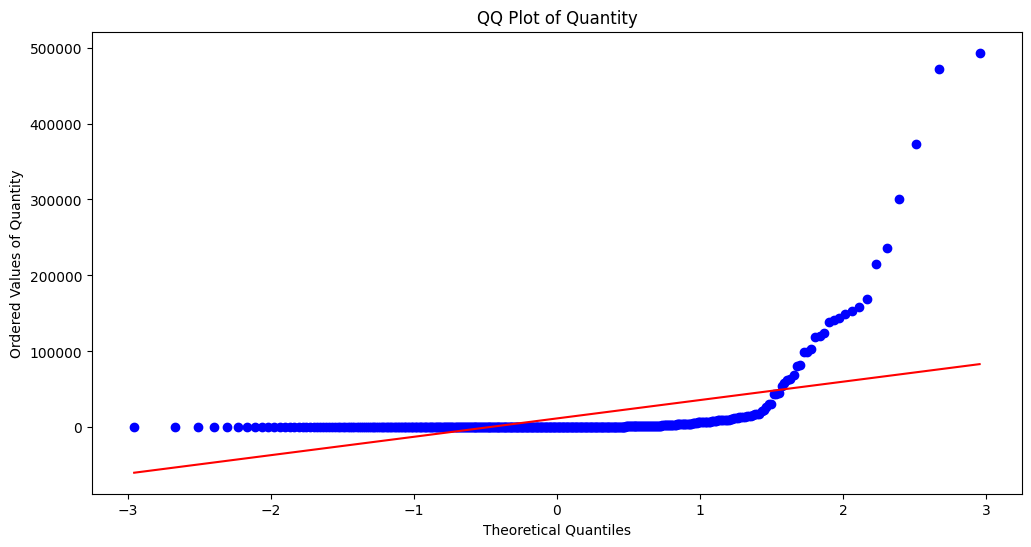

In [33]:
# Display your plot
qq_plot('Quantity', orders_per_price)

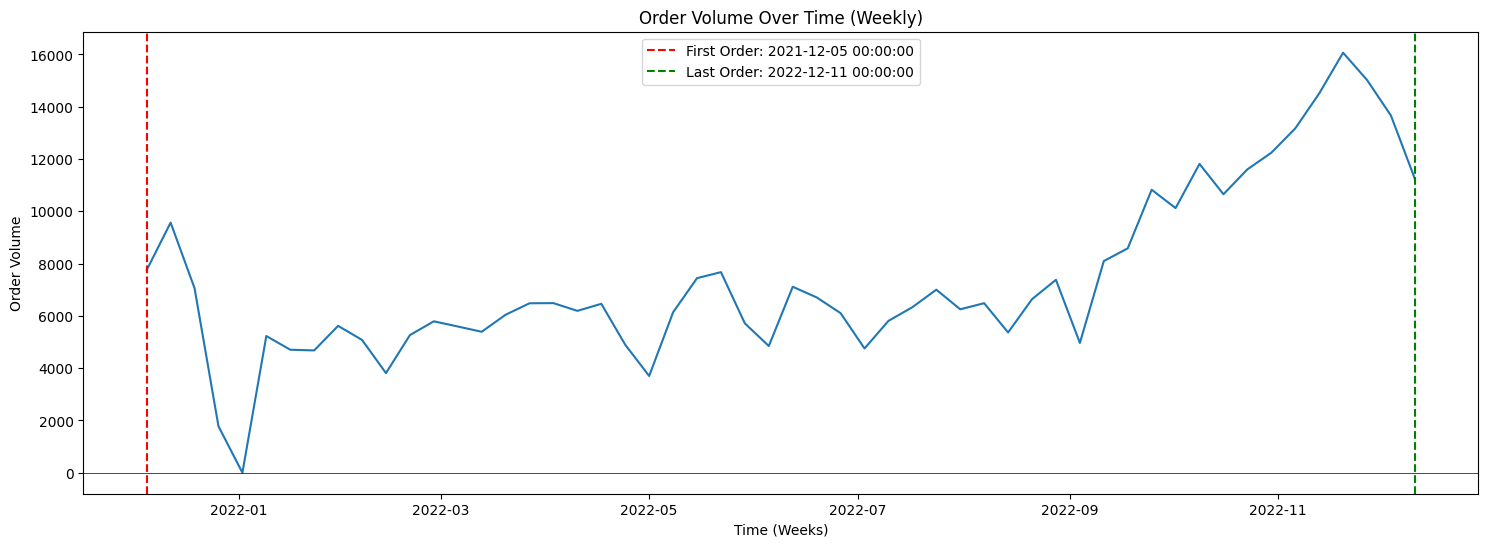

In [120]:
# I want to understand if the data is contigious so that I can
# make sure there are not gaps that could cause problems.

import matplotlib.pyplot as plt

# Group the data by weeks and count the number of orders
order_volume_weekly = data.groupby(pd.Grouper(key='InvoiceDate', freq='W')).size().reset_index(name='OrderVolume')

# Create the plot
plt.figure(figsize=(18, 6))
plt.plot(order_volume_weekly['InvoiceDate'], order_volume_weekly['OrderVolume'])

# Add vertical lines at the first and last order points
first_order_date = order_volume_weekly['InvoiceDate'].iloc[0]
last_order_date = order_volume_weekly['InvoiceDate'].iloc[-1]
plt.axvline(first_order_date, color='r', linestyle='--', label=f'First Order: {first_order_date}')
plt.axvline(last_order_date, color='g', linestyle='--', label=f'Last Order: {last_order_date}')

# Add a horizontal line at y=0
plt.axhline(0, color='black', linestyle='-', linewidth=0.5)

# Additional plot settings
plt.xlabel('Time (Weeks)')
plt.ylabel('Order Volume')
plt.title('Order Volume Over Time (Weekly)')
plt.legend()

plt.show()

### How Likely Is It That CostPro Will Have Enough High-Value Sales?

Your boss at CostPro feels that CostPro needs more "high value"

*   List item
*   List item

sales, where a sale is "high value" if the total price is over $1000. Management has set a goal of at least 350 high value sales per quarter.

Your job is to estimate the likelihood that CostPro will meet this goal. How likely is it to have at least 350 high value sales in a given quarter?

To do this, you can model sales as a binomial distribution. Since we're interested only in high value sales, you can count a sale as a "success" if it's over \$1000, and a failure if it's less than \$1000. To calculate the binomial distribution, you just need the two key values:

1. n, the total number of sales in a given quarter (you can use the mean number of sales in a quarter)
2. p, the probability that a sale is over \$1000 (you can use the overall rate at which sales are over \$1000 in the dataset)

In the cells below, use the sales dataset to get the values of n and p, and then use these to generate a binomial distribution. You can then use this binomial distribution to calculate the probability that there will be at least 350 high value sales in a given quarter.

In [125]:
# Define a utility function to overall probability of any given sale being greater than $1K (p)
def calculate_overall_probability_of_high_value_sale(data: pd.DataFrame, high_value=1000) -> float:
    """
    Calculate the parameters n and p for the binomial distribution for high-value sales in a given quarter.
    :param data: The dataframe containing the data
    :param year: The year to calculate the parameters for
    :param quarter: The quarter to calculate the parameters for
    :return: n, p
    """
    # Calculate the total sale amount for each unique invoice
    data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
    invoice_totals = data.groupby('InvoiceNo')['TotalPrice'].sum().reset_index()

    # Calculate the total number of invoices
    total_number_of_invoices = invoice_totals.shape[0]

    # Calculate the number of high-value invoices where the total sale per order is over $1000
    high_value_invoices = invoice_totals[invoice_totals['TotalPrice'] > 1000].shape[0]

    # Get the overall probability of any given sale being greater than $1K (p)
    p = high_value_invoices / total_number_of_invoices

    return p

# Get total number of invoices for a given quarter
def get_total_invoices(data: pd.DataFrame, year: int, quarter: int) -> int:
    # Filter the data by the given year and quarter
    filtered_data = filter_by_year_and_quarter(data, year, quarter)

    # Calculate the total number of invoices for the given quarter specifically (n)
    return filtered_data['InvoiceNo'].nunique()

# Write a function using the Binomial distribution to calculate the probability at least 350 high-value sales in the given quarter
def customer_purchase_proba(data: pd.DataFrame, year: int, quarter: int) -> float:
    """
    Calculate the probability of at least 350 high-value sales in the given quarter.
    :param data: The dataframe containing the data
    :param year: The year to calculate the probability for
    :param quarter: The quarter to calculate the probability for
    :return: The probability of at least 350 high-value sales in that quarter
    """

    # Get the overall probability of any given sale being greater than $1K (p)
    p = calculate_overall_probability_of_high_value_sale(data)

    # Calculate the total number of invoices for the given quarter specifically (n)
    n = get_total_invoices(data, year, quarter)

    # Generate the binomial distribution
    rv = binom(n, p)

    # Calculate the probability of having at least 350 high-value sales in the given quarter
    proba = 1 - rv.cdf(349)  # 1 - CDF(x) gives the probability of X > x

    return proba

In [128]:
# Call the function for 2022 Q4
print(f'The probability of having at least 350 high-value sales is: {customer_purchase_proba(data)}')

Now, plot the cumulative distribution function for the binomial distribution.

In [142]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple

# A function to dynamically determine the 'interesting' range of x-values for the binomial CDF
def find_interesting_range(n: int, p: float, n_std: int=3) -> Tuple[int, int]:
    """
    Find the 'interesting' range around a target value for the binomial CDF.
    :param n: The number of trials (total sales in the quarter)
    :param p: The probability of success (high-value sale)
    :return: lower_bound, upper_bound
    """

    # Generate the binomial distribution
    rv = binom(n, p)

    # Find the mean and standard deviation of the binomial distribution
    mean, var = rv.stats(moments='mv')
    std = np.sqrt(var)
    # print(f"Standard deviation: {std}")

    # Calculate the 'interesting' range based on the mean and standard deviation
    # accounting for a minimum window size
    lower_bound = int(mean - std*n_std)
    upper_bound = int(mean + std*n_std)

    return lower_bound, upper_bound


# A function to plot the interesting parts of the CDF of the binomial distribution
def plot_binomial_cdf(data: pd.DataFrame) -> None:
    """
    Plot the 'interesting' parts of the cumulative distribution function (CDF) of the binomial distribution for high-value sales in a given quarter.
    :param data: The dataframe containing the data
    :param year: The year to calculate the probability for
    :param quarter: The quarter to calculate the probability for
    """
    # Get the parameters n and p

    # I am doing the below to account for partial quarters when getting the
    # mean number of orders per quarter.

    # Group the data by days and count the number of orders
    order_volume_daily = data.groupby(pd.Grouper(key='InvoiceDate', freq='D')).size()

    # Calculate the average number of orders per day
    avg_orders_per_day = order_volume_daily.mean()

    # Average number of days in a quarter
    avg_days_per_quarter = 365 / 4  # Approximate

    # Scale the average number of orders per day to a quarter
    avg_orders_per_quarter = avg_orders_per_day * avg_days_per_quarter

    # I will use this for n in order to have a general model to use for future quarters
    n = round(avg_orders_per_quarter)

    # Now to get p
    p = calculate_overall_probability_of_high_value_sale(data)

    # Print out for sanity check
    print(f"p={p} n={n}")

    # Find the interesting range
    lower_bound, upper_bound = find_interesting_range(n, p)

    # Generate x values for the 'interesting' range
    x = np.arange(lower_bound, upper_bound+1)

    # Generate the binomial distribution
    rv = binom(n, p)
    y = rv.cdf(x)

    # Find the mean and standard deviation of the binomial distribution
    mean, _ = rv.stats(moments='mv')

    # Find the 1st and 3rd quantiles
    q1 = rv.ppf(0.25)
    q3 = rv.ppf(0.75)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.step(x, y, where='post')
    plt.axvline(x=mean, color='r', linestyle='--', label=f'Mean: {mean}')
    plt.fill_betweenx([0, 1], q1, q3, color='grey', alpha=0.5, label='25th to 75th Percentile Range')
    plt.title(f'Interesting Range of Cumulative Distribution Function (CDF) for High-Value Sales ($1K+)')
    plt.xlabel('Total Number of Sales')
    plt.ylabel('CDF')
    plt.legend()
    plt.grid(True)
    plt.show()


p=0.07126672421234355 n=97087


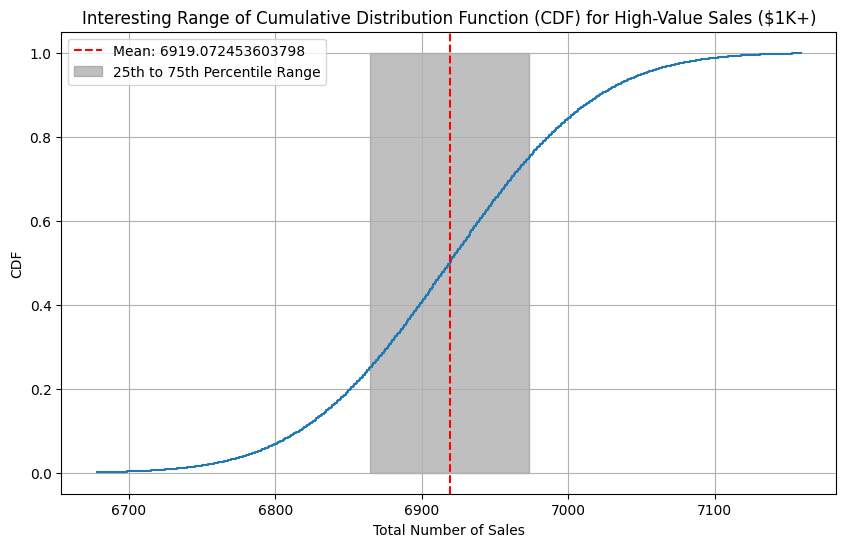

In [143]:
# Visualize the Binomial distribution
plot_binomial_cdf(data)

### How Likely Is It That CostPro Will Have a 10% Increase in Customers On Any Given Day?

Your supervisor wants to know how effective the new marketing campaign is. The day after the campaign was launched, CostPro saw a 10% increase in sales, relative to average number of sales in a day.

Your supervisor wants to know: how likely is it that this was due to random chance?

To help answer this question, you can model customer behavior using the Poisson distribution. In the cells below, use the Poisson distribution to calculate the probability that CostPro has a 10% increase (over the mean) in customers on a given day.

In [ ]:
# Write a function using the Poisson distribution to model how likely a customer is to arrive on the website in the next 15 minutes
def customer_arrival_proba(data: pd.DataFrame, year: int, quarter: int) -> float:
    """
    Calculate the probability of a customer arriving on the website in the next 15 minutes
    :param data: The dataframe containing the data
    :param year: The year to calculate the probability for
    :param quarter: The quarter to calculate the probability for
    :return: The probability of a customer arriving on the website in the next 15 minutes
    """
    # Filter the data by the given year and quarter
    data = filter_by_year_and_quarter(data, year, quarter)

    # Calulate the mean number of customers per day
    <YOUR CODE HERE>

    # Generate the Poisson distribution
    <YOUR CODE HERE>

    # Calculate the probability of having 10% more customers on a given day
    return <YOUR CODE HERE>

In [ ]:
# Call the customer arrival function for 2022 Q4
print(f'The probability of having 10% more customers on a given day is: {<YOUR CODE HERE>}')

In [ ]:
# Write a test to validate the customer arrival function
assert <YOUR CODE HERE>, "There should be no customers for 2022 Q4"

In [ ]:
# Visualize the Poisson distribution for customer visits
def plot_visits_distribution(data):
  <YOUR CODE HERE>


plot_visits_distribution(data)

### Optional

As data scientists it's good practice to make liberal use of `assert` statements throughout notebooks to catch unexpected issues.

We're often reading in large volumes of data created by someone/some process, and analysis in a notebook created once may be reused on newer data as it comes in. Some basic sense checking can save you a lot of headaches down the line.

Examples include:
* am I getting the number of rows I expect from this data?
* is this column that should never be a null, never actually a null?

Can you think of and write some appropriate assert statements?

### Optional

Come Up With Your Own Question, And Answer It With Probability Distributions

## Make a Dashboard for Your Portfolio!

Optional, but ***Highly Encouraged***, Since You've Already Written the Code!

To bring our analysis to life we'll be using a toolkit known as Jupyter Widgets, alongside an interactive plot creation library called Plotly.

At this stage we don't anticipate that you're necessarily familiar with the ins and outs of how Jupyter Widgets function, but the code and links below should help you get started.

You're welcome to modify it as you please. In fact, data visualization is a crucial component of the data science toolkit, so if you're so inclined, give it a try! Some excellent starting points for learning about Jupyter Widgets can be found here, [here](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html), [here](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html), and [here](https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916)!

One potential place to start - can you come up with a better plot type for the data to show outliers? Have a scroll through what the plotly.express library can do [here](https://plotly.com/python/plotly-express/) for inspiration

In [ ]:
import pandas as pd
import plotly.express as px
from ipywidgets import interact, Select, Output, link
from IPython.display import display, clear_output

from google.colab import output
output.enable_custom_widget_manager()

# Create a copy of the data we've processed,
#  in case we want to modify it some more
df = data.copy(deep=True)

# Create an output widget
out = Output()

# Define function to execute on change of filter
def metrics_and_visualization(year, quarter):
  # Filter the data for the selected year and quarter
  filtered_df = filter_by_year_and_quarter(df, year, quarter)

  # Sample our data, to make the visualisation less computionationally intensive
  filtered_df = filtered_df.sample(frac=0.1, random_state=42)

  out.clear_output(wait=True)
  with out:
    # Display the metrics
    print(f"Q{quarter} Customer Purchase Probability: {customer_purchase_proba(filtered_df, year, quarter)}")
    print(f"Q{quarter} Customer Arrival Probability: {customer_arrival_proba(filtered_df, year, quarter)}")

    # Visualise the poisson distribution for customer visits
    plot_visits_distribution(filtered_df)

    # Feel free to add other visualisations here!
    # <YOUR CODE>

# Create a selection widget to choose the quarter
year_widget = Select(options=df["Year"].unique().tolist(), description='Year:')
quarter_widget = Select(options=df["Quarter"].unique().tolist(), description='Quarter:')

# Display widgets
display(year_widget, quarter_widget, out)

# Define function to update quarters widget based on the selected year
def update_quarters(change):
    year = change['new']
    quarters = df[df["Year"] == year]["Quarter"].unique().tolist()
    quarter_widget.options = quarters
    quarter_widget.value = quarters[0] if quarters else None

# Bind the function to changes in the year widget
year_widget.observe(update_quarters, names='value')

# Bind the metrics_and_visualization function to changes in the widgets
def on_change(change):
    metrics_and_visualization(year_widget.value, quarter_widget.value)

quarter_widget.observe(on_change, names='value')

# Call function once to update quarters and display initial data
update_quarters({'new': year_widget.value})
metrics_and_visualization(year_widget.value, quarter_widget.value)

We often want to share visualisations like this with our colleagues and let them play around but without exposing them to all the analysis code we took to get there. Luckily we can easily do this in Colab!
* go to `Edit` -> `Select All Cells`
* go to `View` -> `Show/hide code`

You can also go through and collapse individual sections that you don't want to share (e.g. the bit at the top where we installed some python libraries).

You can then share a link to the notebook (`Share` -> `Copy Link`, setting the `General Access` field appropriately) and then anyone you share the link with can open the notebook, run through it, and see your analysis!

#### 🚀 You Did It!!!

Congratulations, you've completed your second assignment in Applied Statistics for Data Science.